In [1]:
import h5py
import pandas as pd
import os
import pylab as plt
import deepdish as dd
import numpy as np

In [2]:
def get_log_evidence(file):
    data = h5py.File(file)
    log_evidence = data.attrs.get('log_evidence')
    data.close()
    return(log_evidence)

In [3]:
def calc_log_bayes_factor(file1, file2):
    log_ev1 = get_log_evidence(file1)
    log_ev2 = get_log_evidence(file2)
    return(log_ev1-log_ev2)

## Non-spinning injections

In [4]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/injections/hybrids/'

In [5]:
table_metadata = pd.read_csv('hybrids_EccTD_Ebersold_initial_e0_data.csv').set_index('simulation').T
table_e20 = pd.read_csv('e0_hybrids_EccTD_Ebersold_for_20Hz_M_35_Moore.csv').set_index('simulation').T
table_metadata

simulation,BBH_0180,BBH_0184,BBH_0183,BBH_1167,BBH_1221,BBH_1355,BBH_1356,BBH_1357,BBH_1358,BBH_1359,...,BBH_1365,BBH_1366,BBH_1367,BBH_1368,BBH_1369,BBH_1370,BBH_1371,BBH_1372,BBH_1373,BBH_1374
q,1.000,2.000,3.000,2.000,3.000,1.000,1.000,1.000,1.000,1.000,...,2.000,2.000,2.000,2.000,2.000,2.000,3.000,3.000,3.000,3.000
x0,0.045,0.045,0.045,0.045,0.045,0.045,0.045,0.045,0.045,0.045,...,0.045,0.045,0.045,0.045,0.045,0.045,0.045,0.045,0.045,0.045
e0,0.000,0.000,0.000,0.000,0.000,0.120,0.163,0.227,0.227,0.227,...,0.145,0.228,0.228,0.228,0.373,0.373,0.142,0.209,0.209,0.359
l0,0.082,-2.821,-3.121,1.308,2.461,1.423,1.574,0.451,-2.682,1.834,...,-1.127,-2.890,1.687,0.420,-0.203,3.063,0.665,3.005,1.682,3.114
N_orbs,43.600,48.400,56.700,48.500,56.800,41.700,39.900,36.100,35.700,36.300,...,44.900,39.600,40.500,40.300,28.300,28.800,52.800,48.700,48.600,35.000


In [6]:
base_path = '/home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/injections/'
zero_ecc_sim_paths = {'BBH_1132': {'NS':base_path+'/SXSs/BBH_1132/zero_noise/inj3/run01/posterior.hdf',
                                   'AS':base_path+'/SXSs/BBH_1132/zero_noise/inj3/run05/posterior.hdf',
                                   'PS':base_path+'/SXSs/BBH_1132/zero_noise/inj3/run09/posterior.hdf',
                                   'eNS':base_path+'/SXSs/BBH_1132/zero_noise/inj3/run03/posterior.hdf'},
                      
                      'BBH_1167': {'NS':base_path+'/hybrids/BBH_1167/zero_noise/inj2/run01/posterior.hdf', 
                                   'AS':base_path+'/hybrids/BBH_1167/zero_noise/inj2/run12/posterior.hdf', 
                                   'PS':base_path+'/hybrids/BBH_1167/zero_noise/inj2/run15/posterior.hdf',
                                   'eNS':base_path+'/hybrids/BBH_1167/zero_noise/inj2/run05/posterior.hdf'},
                      
                      'BBH_1221': {'NS':base_path+'/hybrids/BBH_1221/zero_noise/inj2/run01/posterior.hdf', 
                                   'AS':base_path+'/hybrids/BBH_1221/zero_noise/inj2/run05/posterior.hdf', 
                                   'PS':base_path+'/hybrids/BBH_1221/zero_noise/inj2/run08/posterior.hdf',
                                   'eNS':base_path+'/hybrids/BBH_1221/zero_noise/inj2/run03/posterior.hdf'}}

In [7]:
pos_files = {}
for sim_num in [1132]+list(range(1355, 1364))+[1167]+list(range(1364,1371))+[1221]+list(range(1371,1375)):
    sim = 'BBH_%s'%sim_num
    if sim in zero_ecc_sim_paths.keys():
        pos_files[sim] = zero_ecc_sim_paths[sim]
    else:
        pos_files[sim] = {}
        for spin_type, run in zip(['NS', 'AS', 'PS', 'eNS'], ['run01', 'run02', 'run03', 'run04']):
            sim_pos_file = os.path.join(base_dir, sim, 
                                        'zero_noise/inj1', run, 'posterior.hdf')
            pos_files[sim][spin_type] = sim_pos_file

In [8]:
def sims_in_q(q):
    sims_list = []
    for sim in pos_files.keys():
        if sim=='BBH_1132':
            if q==1:
                sims_list.append(sim)
            continue
        if table_metadata[sim]['q']==q:
            sims_list.append(sim)
    return(sims_list)

In [9]:
def get_samples_param(param, spin_type, q):
    param_samples_all = []
    
    list_to_iterate = sims_in_q(q)
    
    for sim in list_to_iterate:
        param_samples = dd.io.load(pos_files[sim][spin_type])['samples'][param]
        param_samples_all.append(param_samples)
    return(param_samples_all)

### B(PS/NS)

In [10]:
log_bf_PS_NS = {}
for q in range(1,4):
    for sim in sims_in_q(q):
        ns = pos_files[sim]['NS']
        ps = pos_files[sim]['PS']
        log_bf = calc_log_bayes_factor(ps, ns)
        log_bf_PS_NS[sim] = log_bf

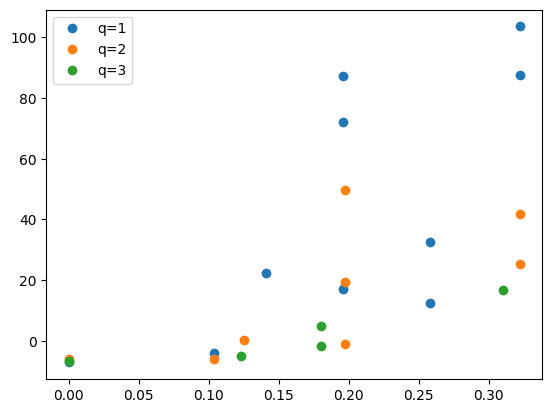

In [12]:
for q in range(1,4):
    e0_vals = []
    for sim in sims_in_q(q):
        if sim=='BBH_1132':
            e0_vals.append(0)
        else:
            e0_vals.append(table_e20[sim]['e0'])
    plt.plot(e0_vals, [log_bf_PS_NS[sim] for sim in sims_in_q(q)], 'o', label=f'q={q}')
plt.legend()

In [46]:
for sim in sims_in_q(2):
    print(sim, table_e20[sim]['e0'], table_metadata[sim]['N_orbs'])

BBH_1167 0.0 48.5
BBH_1364 0.104 46.0
BBH_1365 0.125 44.9
BBH_1366 0.197 39.6
BBH_1367 0.197 40.5
BBH_1368 0.197 40.3
BBH_1369 0.322 28.3
BBH_1370 0.322 28.8


### B(eNS/PS)

In [13]:
log_bf_eNS_PS = {}
for q in range(1,4):
    for sim in sims_in_q(q):
        ens = pos_files[sim]['eNS']
        ps = pos_files[sim]['PS']
        log_bf = calc_log_bayes_factor(ens, ps)
        log_bf_eNS_PS[sim] = log_bf

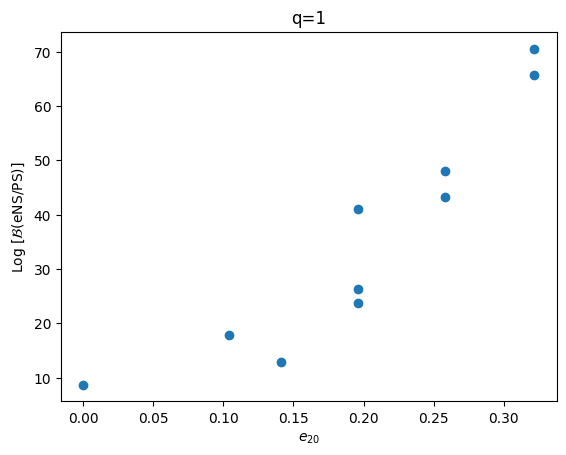

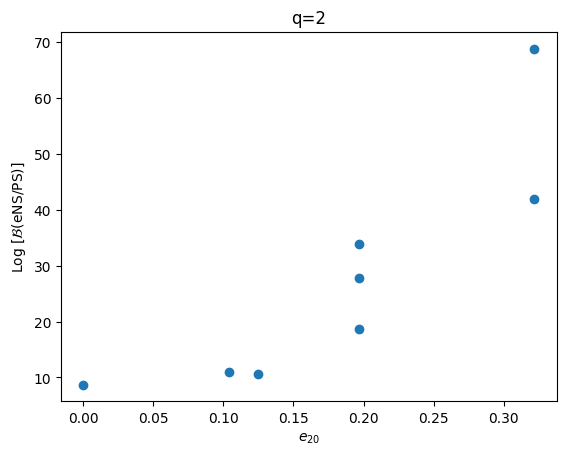

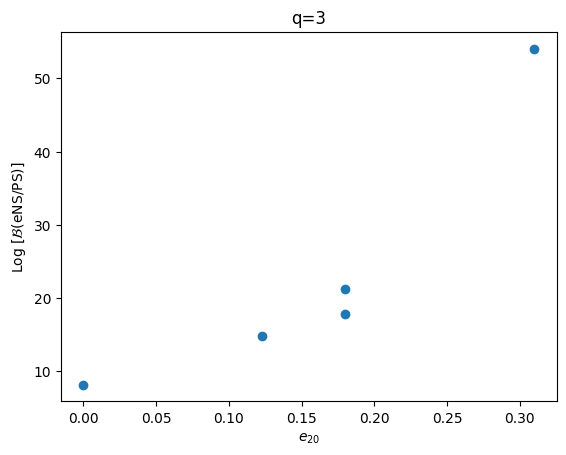

In [16]:
for q in range(1,4):
    plt.figure()
    e0_vals = []
    for sim in sims_in_q(q):
        if sim=='BBH_1132':
            e0_vals.append(0)
        else:
            e0_vals.append(table_e20[sim]['e0'])
    plt.plot(e0_vals, [log_bf_eNS_PS[sim] for sim in sims_in_q(q)], 'o', label=f'q={q}')
    plt.title(f'q={q}')
    plt.xlabel('$e_{20}$')
    plt.ylabel('Log [$\mathcal{B}$(eNS/PS)]')

## Aligned-spin injections

In [4]:
base_path = '/home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/injections/TEOBResumS-DALI/'

In [5]:
run_nums = {'AS':'run01', 
            'PS':'run02',
            'eNS': 'run03',
            'eAS':'run04',
            'insp-AS':'run05',
            'insp-PS':'run06'}

inj_nums = {}
for inj_num, ecc in zip(range(1,9), np.around(np.arange(0,0.4,0.05),2)):
    inj_nums[ecc] = 'inj%s'%inj_num

In [6]:
old_base_path = '/home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/injections/data_from_Isobel/zero_noise/'
old_paths = {'q_2.0': {0.0: {'AS':old_base_path+'inj10/run01/posterior.hdf',
                             'eAS':old_base_path+'inj10/run02/posterior.hdf',
                             'insp-AS':old_base_path+'inj10/run10/posterior.hdf',
                             'PS':old_base_path+'inj10/run03/posterior.hdf', 
                             'insp-PS':old_base_path+'inj10/run05/posterior.hdf'},
                       
                       0.1: {'AS':old_base_path+'inj11/run01/posterior.hdf',
                             'eAS':old_base_path+'inj11/run02/posterior.hdf',
                             'insp-AS':old_base_path+'inj11/run09/posterior.hdf',
                             'PS':old_base_path+'inj11/run03/posterior.hdf', 
                             'insp-PS':old_base_path+'inj11/run05/posterior.hdf'}}, 
             
             'q_3.0': {0.0: {'AS':old_base_path+'inj12/run01/posterior.hdf', 
                             'eAS':old_base_path+'inj12/run02/posterior.hdf', 
                             'insp-AS':old_base_path+'inj12/run08, posterior.hdf', 
                             'PS':old_base_path+'inj12/run03/posterior.hdf', 
                             'insp-PS':old_base_path+'inj12/run05/posterior.hdf'}, 
                       
                       0.1: {'AS':old_base_path+'inj13/run01/posterior.hdf', 
                             'eAS':old_base_path+'inj13/run02/posterior.hdf', 
                             'insp-AS':old_base_path+'inj13/run07/posterior.hdf', 
                             'PS':old_base_path+'inj13/run03/posterior.hdf', 
                             'insp-PS':old_base_path+'inj13/run05/posterior.hdf'}}}

In [7]:
def get_file_path(q, ecc_value, spin_type):
    if (q==2 or q==3) and (ecc_value==0 or ecc_value==0.1):
        path = old_paths['q_{}'.format(float(q))][ecc_value][spin_type]
    else:
        path = os.path.join(base_path, 'q_{}'.format(float(q)), 
                            'spin1z_0.3_spin2z_0.3', 'zero_noise', 
                            inj_nums[ecc_value], run_nums[spin_type], 'posterior.hdf')
    return(path)

In [8]:
def get_samples_param_AS(param, q, spin_type):
    param_samples_all = []
    
    for ecc_value in np.around(np.arange(0,0.4,0.05), 2):
        print(ecc_value)
        if (q==2 or q==3) and (ecc_value==0.0 or ecc_value==0.1):
            param_samples = dd.io.load(old_paths['q_{}'.format(float(q))][ecc_value][spin_type])['samples'][param]
        else:
            param_samples = dd.io.load(get_file_path(q, ecc_value, spin_type))['samples'][param]
        param_samples_all.append(param_samples)
    return(param_samples_all)

In [9]:
e0_vals = np.around(np.arange(0,0.4,0.05), 2)

### B(PS/AS)

In [10]:
log_bf_PS_AS = {}
for q in [1.25, 2, 3]:
    log_bf_PS_AS[q] = {}
    for ecc_value in e0_vals:
        as1 = get_file_path(q, ecc_value, 'AS')
        ps = get_file_path(q, ecc_value, 'PS')
        log_bf = calc_log_bayes_factor(ps, as1)
        log_bf_PS_AS[q][ecc_value] = log_bf

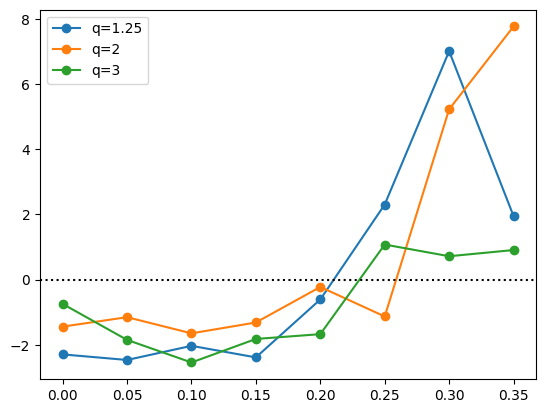

In [11]:
for q in [1.25, 2, 3]:
    plt.plot(e0_vals, [log_bf_PS_AS[q][e0_val] for e0_val in e0_vals], '-o', label=f'q={q}')
plt.axhline(0, color='k', ls=':')
plt.legend()

### B(eAS/iPS)

In [12]:
log_bf_eAS_iPS = {}
for q in [1.25, 2, 3]:
    log_bf_eAS_iPS[q] = {}
    for ecc_value in e0_vals:
        eas = get_file_path(q, ecc_value, 'eAS')
        ips = get_file_path(q, ecc_value, 'insp-PS')
        log_bf = calc_log_bayes_factor(eas, ips)
        log_bf_eAS_iPS[q][ecc_value] = log_bf

In [13]:
df_2 = pd.DataFrame({'eccentricity': e0_vals, 
                     'log_bf_eAS_iPS': [log_bf_eAS_iPS[2][e0_val] for e0_val in e0_vals]})
df_2.to_csv('/home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/TEOBResumS_log_bf_eAS_iPS_q_2.csv', index=False)

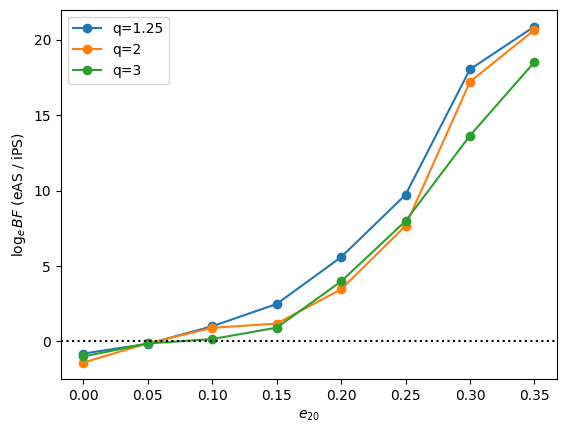

In [15]:
for q in [1.25, 2, 3]:
#for q in [2]:
    plt.plot(e0_vals, [log_bf_eAS_iPS[q][e0_val] for e0_val in e0_vals], '-o', label=f'q={q}')
plt.axhline(0, color='k', ls=':')
#plt.axhline(8, color='k', ls=':')
plt.ylabel('$\log_e BF$ (eAS / iPS)')
plt.legend()
plt.xlabel('$e_{20}$')
plt.savefig('/home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/plots/TEOBResumS-DALI/log_bf_eAS_iPS_q_2.pdf')

### B(eAS/PS)

In [16]:
log_bf_eAS_PS = {}
for q in [1.25, 2, 3]:
    log_bf_eAS_PS[q] = {}
    for ecc_value in e0_vals:
        eas = get_file_path(q, ecc_value, 'eAS')
        ps = get_file_path(q, ecc_value, 'PS')
        log_bf = calc_log_bayes_factor(eas, ps)
        log_bf_eAS_PS[q][ecc_value] = log_bf

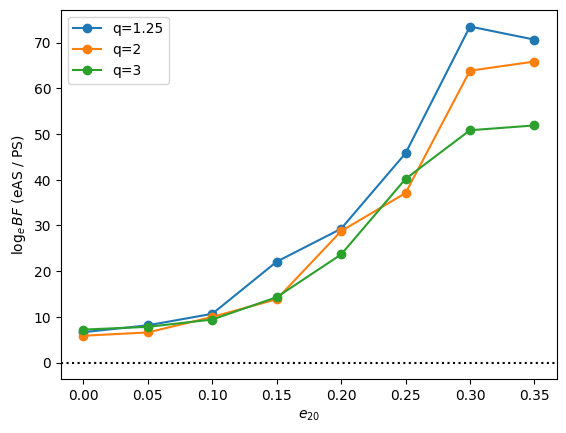

In [17]:
for q in [1.25, 2, 3]:
#for q in [2]:
    plt.plot(e0_vals, [log_bf_eAS_PS[q][e0_val] for e0_val in e0_vals], '-o', label=f'q={q}')
plt.axhline(0, color='k', ls=':')
#plt.axhline(8, color='k', ls=':')
plt.ylabel('$\log_e BF$ (eAS / PS)')
plt.legend()
plt.xlabel('$e_{20}$')
plt.savefig('/home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/plots/TEOBResumS-DALI/log_bf_eAS_PS_q_2.pdf')

In [85]:
df_2 = pd.DataFrame({'eccentricity': e0_vals[:-1], 
                     'log_bf_eAS_PS': [log_bf_eAS_PS[2][e0_val] for e0_val in e0_vals[:-1]]})
df_2.to_csv('/home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/TEOBResumS_log_bf_eAS_PS_q_2.csv', index=False)

### B(eAS/AS)

In [17]:
log_bf_eAS_AS = {}
for q in [1.25, 2, 3]:
    log_bf_eAS_AS[q] = {}
    for ecc_value in e0_vals:
        eas = get_file_path(q, ecc_value, 'eAS')
        as0 = get_file_path(q, ecc_value, 'AS')
        log_bf = calc_log_bayes_factor(eas, as0)
        log_bf_eAS_AS[q][ecc_value] = log_bf

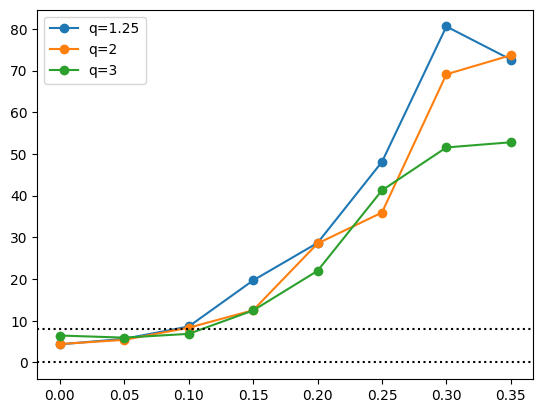

In [26]:
for q in [1.25, 2, 3]:
    plt.plot(e0_vals, [log_bf_eAS_AS[q][e0_val] for e0_val in e0_vals], '-o', label=f'q={q}')
plt.axhline(0, color='k', ls=':')
plt.axhline(8, color='k', ls=':')
plt.legend()

In [24]:
log_bf_eAS_AS[1.25][0.2], log_bf_eAS_AS[2][0.2]

(np.float64(28.669415522356374), np.float64(28.529423514330915))

## Precessing spin injections

In [28]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/'
run_dir_base = os.path.join(base_dir, 'injections/ICTS_sims')
plot_dir = os.path.join(base_dir, 'plots')
ecc_spin_run_nums = {'PS': 'run01',
                     'eAS': 'run02'}

In [29]:
sims_at_highest_lev = {'names':[], 'meta_files':[], 'levs':[]}
for lev in ['Lev4', 'Lev3', 'Lev2']:
    sim_list = list(os.walk(os.path.join(run_dir_base, lev)))[0][1]
    sim_list.sort()
    for sim in sim_list:
        if sim not in sims_at_highest_lev['names']:
            sims_at_highest_lev['names'].append(sim)
            sims_at_highest_lev['meta_files'].append(os.path.join(run_dir_base, 
                                                                  lev, 
                                                                  sim, 
                                                                  'zero_noise',
                                                                  'inj1',
                                                                  'metadata.txt'))
            sims_at_highest_lev['levs'].append(lev)

In [44]:
def get_param_inj_val_from_metadata(meta_file, param, round_to=4):
    with open(meta_file, 'r') as f:
        metadata_text = f.read().splitlines()

    while(1):
        try:
            metadata_text.remove('')
        except ValueError:
            break
    
    metadata_text = [line.strip().replace('\\t', '') for line in metadata_text]
    for line in metadata_text:
        if '=' not in line or '===>' in line:
            continue
        param_metadata, val = ''.join(line.split()).split('=')
        return_val = val
        if param == 'spin1z' and param_metadata == 'ChiA_ref':
            return_val = eval(val)[-1]
            break
        elif param == 'spin2z' and param_metadata == 'ChiB_ref':
            return_val = eval(val)[-1]
            break
        elif param_metadata == param:
            break
        elif param in pycbc_to_metadata_dict.keys():
            if param_metadata == pycbc_to_metadata_dict[param]:
                break
    else:
        raise ValueError(f'{param} value not found')
    return(round(float(return_val), round_to))

In [39]:
def get_file_path(sim_name, recovery_type):
    sim_idx = sims_at_highest_lev['names'].index(sim_name)
    lev = sims_at_highest_lev['levs'][sim_idx]
    path = os.path.join(run_dir_base, lev, sim_name, 
                        'zero_noise', 'inj1', 
                        ecc_spin_run_nums[recovery_type], 'posterior.hdf')
    return(path)

In [46]:
pycbc_to_metadata_dict = {
    'chi_eff': 'chi_eff_ref',
    'chi_p': 'chi_p_ref',
    'distance': 'DL',
    'mass1': 'm1',
    'mass2': 'm2',
    'mchirp': 'm_chirp',
    'mtotal': 'M',
    'polarization': 'pol',
    'eccentricity': 'Eccentricity'
}

keys_not_in_metadata = {
    'coa_phase': 0, 
    'delta_tc': 0,
    'loglikelihood': None,
    'logwt': None
}

In [54]:
inj_vals = {
    'sim_names': [],
    'mchirp': [],
    'chi_eff': [],
    'chi_p': [],
    'mtotal': [],
    'q': [],
    'eccentricity': [],
    'log_bf_eAS_PS': []
}
for sim, meta_file in zip(sims_at_highest_lev['names'], sims_at_highest_lev['meta_files']):
    inj_vals['sim_names'].append(sim)
    for param in list(inj_vals.keys())[1:-1]:
        inj_vals[param].append(get_param_inj_val_from_metadata(meta_file, param))
    eas = get_file_path(sim, 'eAS')
    ps = get_file_path(sim, 'PS')
    log_bf = calc_log_bayes_factor(eas, ps)
    inj_vals['log_bf_eAS_PS'].append(log_bf)
inj_vals_df = pd.DataFrame(inj_vals).set_index('sim_names')

In [59]:
inj_vals_df

,mchirp,chi_eff,chi_p,mtotal,q,eccentricity,log_bf_eAS_PS
sim_names,,,,,,,
EccContPrecDiff001,13.1857,0.0253,0.3000,36.0,3.0,0.04,5.068439
EccContPrecDiff003,35.5784,-0.0676,0.2236,102.0,3.5,0.10,23.706183
EccContPrecDiff004,38.6868,0.3474,0.2952,89.0,1.1,0.15,56.404465
EccContPrecDiff005,43.9628,0.0046,0.4999,101.0,1.0,0.18,44.524325
EccContPrecDiff006,49.2702,0.2033,0.4217,116.0,1.5,0.21,117.019219
EccContPrecDiff007,27.7469,0.0025,0.4123,72.0,2.5,0.08,25.480309
EccContPrecDiff008,17.4110,0.0013,0.5000,40.0,1.0,0.18,11.254087
EccPrecDiff002,13.0583,0.1997,0.2005,30.0,1.0,0.10,69.292238
ICTSEccParallel01,19.7786,0.0005,0.3000,54.0,3.0,0.04,15.475683


In [58]:
inj_vals_df.to_csv(os.path.join(base_dir, 'ICTSSims_log_bf_eAS_PS.csv'))